# 3D Zernike Polynomial Patches

This file provides an example use case for the scripts available in this github repository. If you want to run the example for yourself, copy the script files (get_patch_coords and Zernike_Polynomials) and the data file (1kem.ply) into this directory

In [1]:
from get_patch_coords import *
from Zernike_Polynomials import *

import numpy as np
import matplotlib.pyplot as plt

# setting seed for replicability
np.random.seed(42)

Read in the protein surface ply file (from EDTSurf). This file contains a list of surface points (x,y,z) and a color coded feature (r,g,b) corresponding to each surface point. For this example, each point is color coded by nearest atom type.

In [2]:

vertices, faces = read_ply("1kem.ply")

print(len(vertices)) # ply files contain many surface points

vertices[:3]
# returns a list of x, y, z coordinates and r, g, b color code designation from EDTSurf

203952


[[-26.88, -18.338, -27.48, 226.0, 14.0, 226.0],
 [-26.993, -18.104, -27.437, 226.0, 14.0, 226.0],
 [-26.927, -18.116, -27.713, 226.0, 14.0, 226.0]]

Using the surface information, create a dictionary of 2 unique patches with radii of 8 angstroms

In [3]:
patch_dict = make_surface_patches(vertices,n_patches=2,patch_radius=8,atom_centers=None)

patch_dict
# returns a dictionary of patches
# keys are named by the index of the patch center coordinate (from vertices)
# The point at the patch center is listed first
# Coordinate information is listed first, followed by the feature array

{18202: (array([[-18.458, -14.299, -36.312],
         [-24.548, -11.339, -32.664],
         [-24.661, -11.144, -32.664],
         ...,
         [-11.906, -10.147, -37.888],
         [-11.934, -10.009, -37.599],
         [-11.932,  -9.899, -37.341]]),
  array([[255., 255., 255.],
         [255.,   0.,   0.],
         [255.,   0.,   0.],
         ...,
         [255.,   0.,   0.],
         [255.,   0.,   0.],
         [255.,   0.,   0.]])),
 157849: (array([[ 7.001,  6.497, 11.613],
         [-0.775,  5.963,  9.861],
         [-0.598,  5.13 ,  9.55 ],
         ...,
         [14.483,  4.423, 10.112],
         [14.483,  4.648,  9.585],
         [14.483,  4.574,  9.848]]),
  array([[255.,   0.,   0.],
         [255., 255., 255.],
         [255., 255., 255.],
         ...,
         [255., 255., 255.],
         [255., 255., 255.],
         [255., 255., 255.]]))}

Lets look at the size of our patches.

In [4]:
keys = [key for key in patch_dict.keys()]

# ignoring feature sizes for now
first_patch = patch_dict[keys[0]][0]
second_patch = patch_dict[keys[1]][0]

print(np.shape(first_patch))
np.shape(second_patch)
# our patches contain much fewer surface points (~4,000) compared to the entire protein surface (~200,000)
# the number of points per patch can vary significantly based on geometry

(3454, 3)


(4607, 3)

To approximate the patch surfaces with Zernike polynomials, they must first be scaled. \
Lets look at just the first patch (18202.)

In [5]:
scaled_dict = scale_patch(patch_dict)

keys = [key for key in scaled_dict.keys()]

scale_patch = scaled_dict[keys[0]]

scale_patch
# now the patch coordinates are scaled
# the patch center is now at [0,0,0] and all points fall within a radius of 1
# features remain untouched

(array([[ 0.      ,  0.      ,  0.      ],
        [-0.76125 ,  0.37    ,  0.456   ],
        [-0.775375,  0.394375,  0.456   ],
        ...,
        [ 0.819   ,  0.519   , -0.197   ],
        [ 0.8155  ,  0.53625 , -0.160875],
        [ 0.81575 ,  0.55    , -0.128625]]),
 array([[255., 255., 255.],
        [255.,   0.,   0.],
        [255.,   0.,   0.],
        ...,
        [255.,   0.,   0.],
        [255.,   0.,   0.],
        [255.,   0.,   0.]]))

Now we need to create a voxelized sphere to project our patch into. \
For an example, a 20 x 20 x 20 unit grid (gridpoints=20) is sufficient. \
Only points inside a unit sphere are kept.

In [6]:
voxels, voxel_surf, voxel_feat = voxelize(scale_patch[0],gridpoints=20,feature_array=scale_patch[1])

voxels = np.asarray(voxels)

voxels[150:160], voxel_surf[150:160], voxel_feat[150:160]
# voxelize returns:
# voxels - the coordinates of the voxels (evenly spaced cubes in a unit grid) and
# voxel_surf - the mapping of the surface into the voxelized unit sphere.
# The values in the list are 1 if the voxel contains part of the surface, or 0 if it does not.
# voxel_feat - the mapping of the features to the voxelized grid

(array([[-0.78947368,  0.36842105,  0.36842105],
        [-0.78947368,  0.36842105,  0.47368421],
        [-0.78947368,  0.47368421, -0.36842105],
        [-0.78947368,  0.47368421, -0.26315789],
        [-0.78947368,  0.47368421, -0.15789474],
        [-0.78947368,  0.47368421, -0.05263158],
        [-0.78947368,  0.47368421,  0.05263158],
        [-0.78947368,  0.47368421,  0.15789474],
        [-0.78947368,  0.47368421,  0.26315789],
        [-0.78947368,  0.47368421,  0.36842105]]),
 array([1., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([[255.,   0.,   0.],
        [255.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]]))

Now lets calculate the zernike polynomials for our patch, using a 20th order approximation.

In [7]:
N = 20
z_polys = zernike_polynomials(voxels,N)

# use a simple regression to calculate weights for each term in the 3D Zernike polynomial expansion
zernike_fit = np.linalg.lstsq(z_polys,voxel_surf,rcond=None)[0]


Map the fit back to our voxel coordinates so we can plot it.

In [8]:
zernike_fit = np.matmul(z_polys,zernike_fit)

Creating a plot of the voxelized patch to compare our approximation to. \
The pink area is the patch surface, while the blue area is empty.

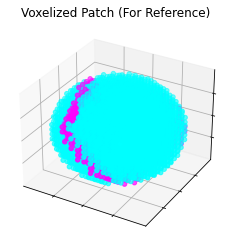

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scat_plot = ax.scatter([i[0] for i in voxels],[i[1] for i in voxels],[i[2] for i in voxels],c=voxel_surf,cmap='cool')
plt.tick_params(labelleft=False,labelbottom=False)
plt.title('Voxelized Patch (For Reference)')
plt.show()


Plotting the result of our fit with the 3D Zernike polynomials. \
It is ok to get a warning about the imaginary components. 

C:\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:4193: ComplexWarning: Casting complex values to real discards the imaginary part
  c = np.asanyarray(c, dtype=float)


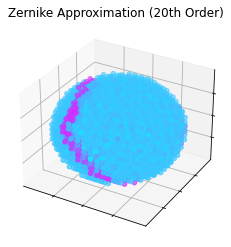

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scat_plot = ax.scatter([i[0] for i in voxels],[i[1] for i in voxels],[i[2] for i in voxels],c=zernike_fit,cmap='cool')
plt.tick_params(labelleft=False,labelbottom=False)
plt.title('Zernike Approximation (20th Order)')
plt.show()


Now we can compute the moments from the Zernike polynomials. \
Finally, we can obtain our rotationally invariant Zernike descriptor.

In [11]:
moments = zernike_moments(z_polys,voxel_surf)

zd = zernike_descriptor(moments)

For a 20th order approximation, our Zernike descriptor is an array of 121 values.

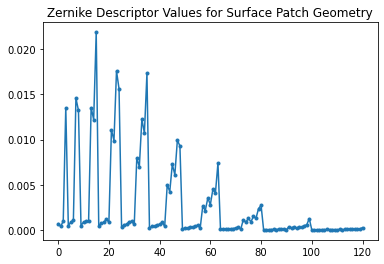

In [12]:
plt.plot(range(len(zd)),zd,'.-')
plt.title('Zernike Descriptor Values for Surface Patch Geometry')
plt.show()

# 3D Zernike Polynomial Features

Lets calculate 3D Zernike Descriptors for features on the protein surface, besides just the surface geometry. For this, we will imagine that each of the rgb codes from EDTSurf is a different custom feature.

In [13]:
# this procedure is very similar to that for the surface mapping
# just replace voxel_surf with voxel_feat for the zernike polynomial fit

# use a simple regression to calculate weights for each term in the 3D Zernike polynomial expansion
zernike_feature_fit = np.linalg.lstsq(z_polys,voxel_feat,rcond=None)[0]
zernike_feature_fit = np.matmul(z_polys,zernike_feature_fit)

Plotting the result of our fit with the 3D Zernike polynomials for our custom features. \
Again, it is ok to get a warning about the imaginary components.

C:\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:4193: ComplexWarning: Casting complex values to real discards the imaginary part
  c = np.asanyarray(c, dtype=float)


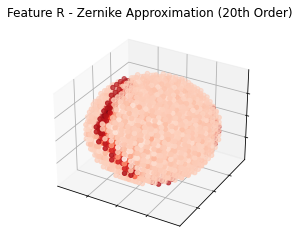

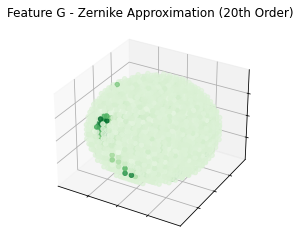

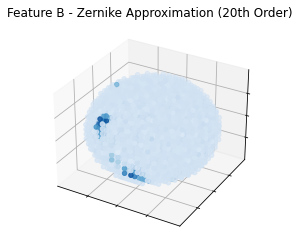

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scat_plot = ax.scatter([i[0] for i in voxels],[i[1] for i in voxels],[i[2] for i in voxels],c=zernike_feature_fit[:,0],cmap='Reds')
plt.tick_params(labelleft=False,labelbottom=False)
plt.title('Feature R - Zernike Approximation (20th Order)')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scat_plot = ax.scatter([i[0] for i in voxels],[i[1] for i in voxels],[i[2] for i in voxels],c=zernike_feature_fit[:,1],cmap='Greens')
plt.tick_params(labelleft=False,labelbottom=False)
plt.title('Feature G - Zernike Approximation (20th Order)')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scat_plot = ax.scatter([i[0] for i in voxels],[i[1] for i in voxels],[i[2] for i in voxels],c=zernike_feature_fit[:,2],cmap='Blues')
plt.tick_params(labelleft=False,labelbottom=False)
plt.title('Feature B - Zernike Approximation (20th Order)')
plt.show()


Now we can compute the moments from the Zernike polynomials for the features. \
Now we can obtain our rotationally invariant feature Zernike descriptors.

In [15]:
feature_moments = zernike_moments(z_polys,voxel_feat)

zd_R = zernike_descriptor(feature_moments[:,0])
zd_G = zernike_descriptor(feature_moments[:,1])
zd_B = zernike_descriptor(feature_moments[:,2])

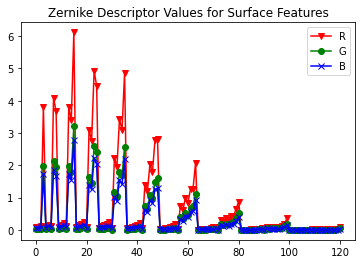

In [16]:
plt.plot(range(len(zd_R)),zd_R,'v-r',label='R')
plt.plot(range(len(zd_G)),zd_G,'o-g',label='G')
plt.plot(range(len(zd_B)),zd_B,'x-b',label='B')
plt.title('Zernike Descriptor Values for Surface Features')
plt.legend()
plt.show()

If we want to use our surface geometry and feature information for each protein patch as inputs for a neural network, we can simply concatenate them.

In [17]:
complete_descriptor = np.concatenate((zd,zd_R,zd_G,zd_B))
np.shape(complete_descriptor)

(484,)